# Assign RegulatoryOverlayUUIDs Values to Water Right sites.csv
Purpose:  To assign RegulatoryOverlayUUIDs values to state water right sites.csv File.

Notes: 
- requires the completed pre-processed sites.csv & watersource.csv files from the state "WaterAllocation/ProcessedInputData" folder to be copied over to the "Regulatory/ProcessedInputData" folder.  Rename to wr_sites.csv & wr_watersource.csv to preserve inputs.
- requires awareness of unique WaterSourceTypeCV of each water right site match up to corresponding WaterSourceTypeCV of regulatoryoverlays per reportingunits

In [1]:
# Needed Libraries / Modules

# ---- working with data ----
import os  # native operating system interaction
import numpy as np  # mathematical array manipulation
import pandas as pd  # data structure and data analysis
import geopandas as gpd  # geo-data structure and data analysis

# ---- visualization ----
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # plotting library
import geoplot as gplt # for plotting maps
import geoplot.crs as gcrs #used to pull in webdata

# ---- API data retrieval ----
import requests  # http requests
import json  # JSON parse

# ---- Cleanup ----
import re  # string regular expression manipulation
from datetime import datetime  # date and time manipulation
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppress scientific notation in Pandas

In [2]:
# ---- working directory ----
workingDirString = "G:/Shared drives/WaDE Data/Nevada/Regulatory" # set working directory folder string here
os.chdir(workingDirString)
print(f'The working Directory is:', workingDirString)

The working Directory is: G:/Shared drives/WaDE Data/Nevada/Regulatory


## Input Data

In [3]:
# Regulatory Input Data
dfro = pd.read_csv("ProcessedInputData/regulatoryoverlays.csv")
dfru = pd.read_csv("ProcessedInputData/reportingunits.csv")
dfrru = pd.read_csv("ProcessedInputData/regulatoryreportingunits.csv")

# Water right Input Data
dfws = pd.read_csv('ProcessedInputData/wr_watersources.csv')
dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', engine = "python", error_bad_lines=False)

C:\Users\rjame\AppData\Local\Temp\ipykernel_6800\447271929.py:8: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', engine = "python", error_bad_lines=False)
Skipping line 39807: field larger than field limit (131072)
Skipping line 39808: field larger than field limit (131072)
Skipping line 39809: field larger than field limit (131072)
Skipping line 39811: field larger than field limit (131072)
Skipping line 39812: field larger than field limit (131072)
Skipping line 39813: field larger than field limit (131072)
Skipping line 39814: field larger than field limit (131072)
Skipping line 39815: field larger than field limit (131072)
Skipping line 39816: field larger than field limit (131072)
Skipping line 39817: field larger than field limit (131072)
Skipping line 39818: field larger than field limit (131072)
Skipping line 39819: field larger than 

In [4]:
#### regulatory watersource info with reporting unit info

# merge regulatoryoverlays -to- regulatoryreportingunits -to- reportingunits
dfro = pd.merge(dfro[['RegulatoryOverlayUUID', 'WaterSourceTypeCV']], dfrru[['RegulatoryOverlayUUID', 'ReportingUnitUUID']], left_on='RegulatoryOverlayUUID', right_on='RegulatoryOverlayUUID', how='left')
dfru = pd.merge(dfru, dfro, left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')

print(dfru['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(dfru['ReportingUnitTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfru))
dfru.head(1)

['Groundwater']
['Groundwater Basin Designations']
139


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,NVre_RUnv022,4326,San Emidio Desert,nv022,NaN,Groundwater Basin Designations,NaN,NV,POLYGON ((-119.37801006921426 40.6619546436668...,NVre_ROnv022,Groundwater


In [5]:
#### water right watersource info with site info

# explode site.csv on WaterSourceUUIDs
dfs = dfs.assign(WaterSourceUUIDs=dfs['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)

# merge watersources to dfs via WaterSourceUUIDs -to -WaterSourceUUID
dfs = pd.merge(dfs, dfws[['WaterSourceUUID', 'WaterSourceTypeCV']], left_on='WaterSourceUUIDs', right_on='WaterSourceUUID', how='left')
print(dfs['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfs))
dfs.head(1)

['Groundwater' 'Surface Water' 'Reservoir' 'Reuse' 'Storage']
61066


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,NVWR_SSitePODwadeID1,NaN,NVWR_WSwadeID1,WaDE Blank,Digitized,Humboldt,4326,NaN,NaN,NaN,NaN,41.98573,-118.62207,NaN,NaN,POD,001 N47 E30 04A 1,SitePODwadeID1,NaN,WaDE Blank,NV,NaN,NVWR_WSwadeID1,Groundwater


## Extract RegulatoryOverlay from Reporting Units and assing to WR Sites
- repeat scripts based on the number of ReportingUnitTypeCV types.
- merge all geo-dataframes into one output

#### Regulatory Area Data #1

In [6]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru1 = dfru.copy()
nameOfReportingUnitTypeVar = "Groundwater Basin Designations" # change here for ReportingUnitTypeCV of interest
dfru1 = dfru1[dfru1['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru1))
print(dfru1['WaterSourceTypeCV'].unique())
dfru1.head(1)

139
['Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,NVre_RUnv022,4326,San Emidio Desert,nv022,NaN,Groundwater Basin Designations,NaN,NV,POLYGON ((-119.37801006921426 40.6619546436668...,NVre_ROnv022,Groundwater


<GeoAxesSubplot: >

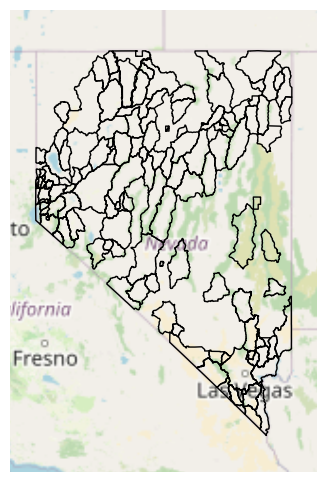

In [7]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru1 = dfru1[dfru1['Geometry'] != ""].reset_index(drop=True)
dfru1['Geometry'] = gpd.GeoSeries.from_wkt(dfru1['Geometry'], crs="EPSG:4326")
gdfru1 = gpd.GeoDataFrame(dfru1, geometry=dfru1['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru1, ax=ax)

In [8]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs1 = dfs.copy()
nameOfWaterSourceTypeCV= "Groundwater" # change here for WaterSourceTypeCV of interest
dfs1 = dfs1[dfs1['WaterSourceTypeCV'] == nameOfWaterSourceTypeCV]
dfs1 = dfs1[dfs1['PODorPOUSite'] == 'POD']
print(len(dfs1))
print(dfs1['WaterSourceTypeCV'].unique())
dfs1.head(1)

17969
['Groundwater']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,NVWR_SSitePODwadeID1,NaN,NVWR_WSwadeID1,WaDE Blank,Digitized,Humboldt,4326,NaN,NaN,NaN,NaN,41.98573,-118.62207,NaN,NaN,POD,001 N47 E30 04A 1,SitePODwadeID1,NaN,WaDE Blank,NV,NaN,NVWR_WSwadeID1,Groundwater


<GeoAxesSubplot: >

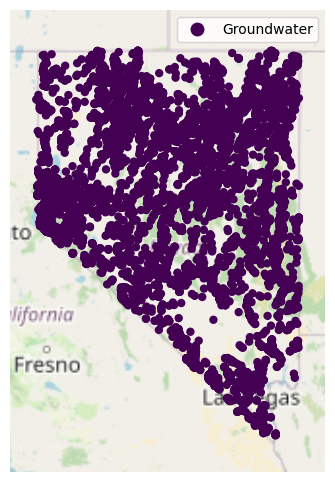

In [9]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs1 = gpd.GeoDataFrame(dfs1, geometry=gpd.points_from_xy(dfs1.Longitude.astype(float), dfs1.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [10]:
# Select sites within polygon.
gdfs1_ru1 = gpd.sjoin(left_df=gdfs1, right_df=gdfru1[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs1_ru1))
gdfs1_ru1.head()

14987


C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
2,NVWR_SSitePODwadeID100007,,NVWR_WSwadeID1,WaDE Blank,Digitized,Lincoln,4326,,,,,37.58361,-115.22664,,,POD,209 S04 E60 23Cbbc1,SitePODwadeID100007,,WaDE Blank,NV,,NVWR_WSwadeID1,Groundwater,POINT (-115.22664 37.58361),124,NVre_RUnv209,NVre_ROnv209
60,NVWR_SSitePODwadeID100191,,NVWR_WSwadeID1,WaDE Blank,Digitized,Lincoln,4326,,,,,37.60634,-115.22652,,,POD,209 S04 E60 14Bbbb1,SitePODwadeID100191,,WaDE Blank,NV,,NVWR_WSwadeID1,Groundwater,POINT (-115.22652 37.60634),124,NVre_RUnv209,NVre_ROnv209
64,NVWR_SSitePODwadeID100212,,NVWR_WSwadeID1,WaDE Blank,Digitized,Lincoln,4326,,,,,37.38390,-115.16395,,,POD,209 S06 E61 32Dbbb1,SitePODwadeID100212,,WaDE Blank,NV,,NVWR_WSwadeID1,Groundwater,POINT (-115.16395 37.38390),124,NVre_RUnv209,NVre_ROnv209
65,NVWR_SSitePODwadeID100222,,NVWR_WSwadeID1,WaDE Blank,Digitized,Lincoln,4326,,,,,37.42359,-115.17742,,,POD,209 S06 E61 18Ddba1,SitePODwadeID100222,,WaDE Blank,NV,,NVWR_WSwadeID1,Groundwater,POINT (-115.17742 37.42359),124,NVre_RUnv209,NVre_ROnv209
66,NVWR_SSitePODwadeID100223,,NVWR_WSwadeID1,WaDE Blank,Digitized,Lincoln,4326,,,,,37.42670,-115.18895,,,POD,209 S06 E61 18Cbad1,SitePODwadeID100223,,WaDE Blank,NV,,NVWR_WSwadeID1,Groundwater,POINT (-115.18895 37.42670),124,NVre_RUnv209,NVre_ROnv209


<GeoAxesSubplot: >

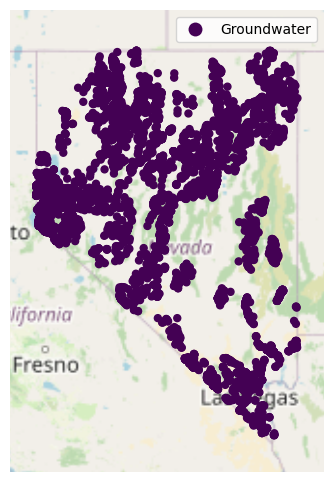

In [11]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs1_ru1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [12]:
# set RegulatoryOverlayUUIDs
gdfs1_ru1['RegulatoryOverlayUUIDs'] = gdfs1_ru1['RegulatoryOverlayUUID']
gdfs1_ru1 = gdfs1_ru1.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs1_ru1.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
2,NVWR_SSitePODwadeID100007,NVre_ROnv209,NVWR_WSwadeID1,WaDE Blank,Digitized,Lincoln,4326,,,,,37.58361,-115.22664,,,POD,209 S04 E60 23Cbbc1,SitePODwadeID100007,,WaDE Blank,NV,


#### Regulatory Area Data #2

In [13]:
# dfru2 = dfru.copy()
# etc etc

## Concatenate all Regulatory Area Data Types together
- drop geometry from the wade wr sites.csv geodataframe

In [14]:
# Concatenate dataframes into single output
frames = [dfs, gdfs1_ru1] # list all out dataframes here
outdfs = pd.concat(frames)
outdfs = outdfs.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
outdfs = outdfs.groupby('SiteUUID').agg(lambda x: ','.join([str(elem) for elem in (list(set(x))) if elem != ""])).replace(np.nan, "").reset_index()
print(len(outdfs))
outdfs.head(1)

61066


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,NVWR_SSitePODwadeID1,,NVWR_WSwadeID1,WaDE Blank,Digitized,Humboldt,4326,,,,,41.985729,-118.622074,,,POD,001 N47 E30 04A 1,SitePODwadeID1,,WaDE Blank,NV,,NVWR_WSwadeID1,Groundwater


# Inspect Output Data & Export

In [15]:
outdfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61066 entries, 0 to 61065
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   SiteUUID                61066 non-null  object
 1   RegulatoryOverlayUUIDs  61066 non-null  object
 2   WaterSourceUUIDs        61066 non-null  object
 3   CoordinateAccuracy      61066 non-null  object
 4   CoordinateMethodCV      61066 non-null  object
 5   County                  61066 non-null  object
 6   EPSGCodeCV              61066 non-null  object
 7   Geometry                61066 non-null  object
 8   GNISCodeCV              61066 non-null  object
 9   HUC12                   61066 non-null  object
 10  HUC8                    61066 non-null  object
 11  Latitude                61066 non-null  object
 12  Longitude               61066 non-null  object
 13  NHDNetworkStatusCV      61066 non-null  object
 14  NHDProductCV            61066 non-null  object
 15  PO

In [16]:
outdfs

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,NVWR_SSitePODwadeID1,,NVWR_WSwadeID1,WaDE Blank,Digitized,Humboldt,4326,,,,,41.985729,-118.622074,,,POD,001 N47 E30 04A 1,SitePODwadeID1,,WaDE Blank,NV,,NVWR_WSwadeID1,Groundwater
1,NVWR_SSitePODwadeID100004,,NVWR_WSwadeID2,WaDE Blank,Digitized,Lincoln,4326,,,,,37.463316,-115.192275,,,POD,209 S06 E61 06Bbbb1,SitePODwadeID100004,,WaDE Blank,NV,,NVWR_WSwadeID2,Surface Water
2,NVWR_SSitePODwadeID100007,NVre_ROnv209,NVWR_WSwadeID1,WaDE Blank,Digitized,Lincoln,4326,,,,,37.583609,-115.226635,,,POD,209 S04 E60 23Cbbc1,SitePODwadeID100007,,WaDE Blank,NV,,NVWR_WSwadeID1,Groundwater
3,NVWR_SSitePODwadeID100017,NVre_ROnv218,NVWR_WSwadeID1,WaDE Blank,Digitized,Clark,4326,,,,,36.658479,-114.63187,,,POD,218 S15 E66 05Caac1,SitePODwadeID100017,,WaDE Blank,NV,,NVWR_WSwadeID1,Groundwater
4,NVWR_SSitePODwadeID100022,NVre_ROnv218,NVWR_WSwadeID1,WaDE Blank,Digitized,Clark,4326,,,,,36.544486,-114.802059,,,POD,218 S16 E64 15Adaa1,SitePODwadeID100022,,WaDE Blank,NV,,NVWR_WSwadeID1,Groundwater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61061,NVWR_SSitePOUwadeID9995,,NVWR_WSwadeID2,WaDE Blank,Digitized,Washoe,4326,MULTIPOLYGON (((-119.813611246 39.243985546000...,,,,39.239135,-119.833277,,,POU,089 N16 E19 22Acac1,SitePOUwadeID9995,,WaDE Blank,NV,,NVWR_WSwadeID2,Surface Water
61062,NVWR_SSitePOUwadeID9996,,NVWR_WSwadeID1,WaDE Blank,Digitized,Washoe,4326,MULTIPOLYGON (((-119.813611246 39.243985546000...,,,,39.23493,-119.83217,,,POU,089 N16 E19 22Dbda1,SitePOUwadeID9996,,WaDE Blank,NV,,NVWR_WSwadeID1,Groundwater
61063,NVWR_SSitePOUwadeID9997,,NVWR_WSwadeID1,WaDE Blank,Digitized,Washoe,4326,MULTIPOLYGON (((-119.813611246 39.243985546000...,,,,39.23413,-119.82876,,,POU,089 N16 E19 22Dadc1,SitePOUwadeID9997,,WaDE Blank,NV,,NVWR_WSwadeID1,Groundwater
61064,NVWR_SSitePOUwadeID9998,,NVWR_WSwadeID1,WaDE Blank,Digitized,Washoe,4326,POLYGON ((-119.81810168299995 39.2345733160000...,,,,39.232687,-119.817918,,,POU,089 N16 E19 23Cdaa1,SitePOUwadeID9998,,WaDE Blank,NV,,NVWR_WSwadeID1,Groundwater


In [17]:
# Export out to CSV.
outdfs.to_csv('ProcessedInputData/sites.csv', index=False) # this is in the Regulatory data folder